# Comparison of different renewal processes inferred Rt profiles

In [1]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
from cmdstanpy import CmdStanModel,  cmdstan_path
import arviz as az
import nest_asyncio
import seaborn as sns
nest_asyncio.apply()

num_timepoints = 30 # number of days for incidence data
num_categories = 3

In [2]:
# # Read contact matrix
# cm_file = 'UK'
# path = os.path.join('../data_library/contact_matrix', '{}.csv'.format(cm_file))
# contact_matrix = pd.read_csv(path, header=None)

# # Read serial interval
# si_file = 'si-epinow'
# path = os.path.join('../data_library/serial_interval', '{}.csv'.format(si_file))
# serial_interval = pd.read_csv(path, header=None)
# serial_interval = serial_interval.fillna(0)
# serial_intervals = serial_interval.values.T

# # Read transmissibility vector
# trans_file = 'UK'
# path = os.path.join('../data_library/transmissibility', '{}.csv'.format(trans_file))
# transmissibility = pd.read_csv(path, header=None)

In [3]:
# # Read Ontario data
# path = os.path.join('../data_library/covid_ontario/ON.csv')
# data = pd.read_csv(path)[:51]

# Data Set 1

## Parameterize example branching process model with disagregated data

In [4]:
# Build the serial interval w_s
ws_mean = 2.6
ws_var = 1.5**2
theta = ws_var / ws_mean
k = ws_mean / theta
w_dist = scipy.stats.gamma(k, scale=theta)
disc_w = w_dist.pdf(np.arange(num_timepoints))

# Simulate incidence data
initial_r = 3
serial_interval = disc_w

# contact_matrix = contact_matrix
contact_matrix = np.array([[1, 0.5, 0.01], [0.3, 1.4, 0.1], [0.2, 0.1, 0.8]])
# contact_matrix = 1 * np.ones((2, 2))

transmissibility = [0.5, 1.2, 0.7]
# transmissibility = [1.5, 1.5]

m = branchpro.MultiCatPoissonBranchProModel(
    initial_r, serial_interval, num_categories, contact_matrix, transmissibility)
new_rs = [3, 0.5]          # sequence of R_0 numbers
start_times = [0, 15]      # days at which each R_0 period begins
m.set_r_profile(new_rs, start_times)
parameters = [20, 50, 30] # initial number of cases
times = np.arange(num_timepoints)

desagg_cases = m.simulate(parameters, times)
agg_cases = np.sum(desagg_cases, axis=1)

print(desagg_cases)

[[2.0000e+01 5.0000e+01 3.0000e+01]
 [0.0000e+00 0.0000e+00 0.0000e+00]
 [2.9000e+01 5.9000e+01 1.7000e+01]
 [4.1000e+01 9.4000e+01 3.2000e+01]
 [6.5000e+01 1.4900e+02 2.9000e+01]
 [1.1500e+02 2.3800e+02 4.7000e+01]
 [1.9900e+02 4.3100e+02 8.6000e+01]
 [3.7000e+02 7.8000e+02 1.1600e+02]
 [5.0800e+02 1.1640e+03 2.0200e+02]
 [1.0180e+03 2.1540e+03 3.0600e+02]
 [1.6310e+03 3.4870e+03 5.2500e+02]
 [2.8260e+03 5.9560e+03 8.3300e+02]
 [4.7000e+03 1.0051e+04 1.4220e+03]
 [8.1750e+03 1.6795e+04 2.4090e+03]
 [1.3359e+04 2.8435e+04 3.9530e+03]
 [2.2744e+04 4.7769e+04 6.8140e+03]
 [6.4650e+03 1.3646e+04 1.8790e+03]
 [1.0778e+04 2.2732e+04 3.1640e+03]
 [1.1364e+04 2.3543e+04 3.3580e+03]
 [1.0545e+04 2.2246e+04 2.9820e+03]
 [1.0205e+04 2.1079e+04 2.9030e+03]
 [9.6510e+03 2.0610e+04 2.8360e+03]
 [9.4190e+03 1.9724e+04 2.6950e+03]
 [8.9760e+03 1.9394e+04 2.6020e+03]
 [8.8320e+03 1.8578e+04 2.6170e+03]
 [8.5810e+03 1.8111e+04 2.4810e+03]
 [8.2440e+03 1.7420e+04 2.3540e+03]
 [7.9460e+03 1.6690e+04 2.41

## Plot agreggated local incidence numbers

In [5]:
# Plot (bar chart cases each day)
fig = go.Figure()

# Plot of incidences
fig.add_trace(
    go.Bar(
        x=times,
        y=agg_cases,
        name='Incidences'
    )
)

# Add axis labels
fig.update_layout(
    xaxis_title='Time (days)',
    yaxis_title='New cases'
)

fig.show()

## R_t inference using STAN

In [6]:
# Same inference, but using the PoissonBranchProPosterior
tau = 6
R_t_start = tau+1
a = 1
b = 1/5
sigma = 1.5

phi_mean = 0.5
phi_var = 10**(-0)
phi_rate = phi_var / phi_mean
phi_shape = phi_mean / phi_rate

# Naive correction for reproduction number per individual
# i.e. no variation in contacts and transmissibility between different categories
N_corr = num_categories * (np.sum(np.matmul(contact_matrix, transmissibility))/np.sum(contact_matrix))

# True correction - only available when we have desaggreagted case data
T_corr = np.empty(num_timepoints - R_t_start)

for _, t in enumerate(np.arange(R_t_start, num_timepoints)):
    T_corr[_] = np.sum(np.matmul(
                    contact_matrix,
                    np.multiply(
                        transmissibility,
                        m._effective_no_infectives(t, desagg_cases)
                    )))/ np.sum(m._effective_no_infectives(t, desagg_cases))

In [7]:
# Same inference, but using the PoissonBranchProPosterior
tau = 6
R_t_start = tau+1
a = 1
b = 1/5
sigma = 1.5

phi_mean = 0.5
phi_var = 10**(-0)
phi_rate = phi_var / phi_mean
phi_shape = phi_mean / phi_rate

# Naive correction for reproduction number per individual
# i.e. no variation in contacts and transmissibility between different categories
N_corr = num_categories * (np.sum(np.matmul(contact_matrix, transmissibility))/np.sum(contact_matrix))

# True correction - only available when we have desaggreagted case data
T_corr = np.empty(num_timepoints - R_t_start)

for _, t in enumerate(np.arange(R_t_start, num_timepoints)):
    T_corr[_] = np.sum(np.matmul(
                    contact_matrix,
                    np.multiply(
                        transmissibility,
                        m._effective_no_infectives(t, desagg_cases)
                    )))/ np.sum(m._effective_no_infectives(t, desagg_cases))

In [8]:
# Transform our incidence data into pandas dataframes
multicat_inc_data_matrix = {'Time': np.arange(num_timepoints)}

for _ in range(num_categories):
    multicat_inc_data_matrix['Incidence Number Cat {}'.format(_+1)] = \
        desagg_cases[:, _]

multicat_inc_data = pd.DataFrame(multicat_inc_data_matrix)

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': agg_cases
    }
)

L1 = len(np.arange(R_t_start, start_times[1]+1))
L2 = len(np.arange(start_times[1]+1, num_timepoints))

ground_truth = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'R_t': L1*[3] + L2*[0.5]
})

### Desaggregated data + Poisson Branching process with multiple categories

In [9]:
multicat_model = """
functions {
    real normalizing_const (array [] real aSI) {
        return sum(aSI);
    }
    real effective_no_infectives (
        int N, int S, int n, int i, int t, array [,] real aI, array [] real aSI,
        array [,] real C, array [] real transm) {
            real mean;

            mean = 0;
            for(j in 1:n){
                if(t > S) {
                    mean += C[i,j] * transm[j] * (
                        dot_product(aI[(t-S):(t-1), j], aSI) /
                        normalizing_const(aSI));
                }
                else {
                    mean += C[i,j] * transm[j] * (
                        dot_product(aI[:(t-1), j], aSI[(S-t+2):]) /
                        normalizing_const(aSI));
                }
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length serial interval
    int n; // number of categories
    array [n, n] real C; // contact matrix
    array [n] real transm; // transmissibility vector
    array [N, n] int I; // local incidences for N days
    int tau; // sliding window
    array [S] real revSI; // reversed serial interval
    real a; // prior shape parameter
    real b; // prior rate parameter
    real<lower=0> sigma; // prior std parameter
}
parameters {
    array [N-tau-1] real<lower=0> R; // vector of R numbers
}
model {
    for(t in (tau+1):(N-1)) {
        for (i in 1:n){
            for(k in (t-tau+1):(t+1)) {
                if (effective_no_infectives(N, S, n, i, k, I, revSI, C, transm) != 0) {
                    I[k, i] ~ poisson (
                        R[t-tau] * effective_no_infectives(
                            N, S, n, i, k, I, revSI, C, transm)); // likelihood
                        }
            }
        }
    }
    for(t in 1:(N-tau-1)) {
        R[t] ~ gamma (a, b); // prior of R
    }
}
"""

multicat_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'n': num_categories,
    'C': contact_matrix,
    'transm': transmissibility,
    'I': desagg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b,
    'sigma': sigma}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_11168/4092849573.py:67: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [10]:
posterior = stan.build(
    multicat_model, data=multicat_data, random_seed=10)

fit = posterior.sample(
    num_chains=3, num_samples=1000)

samples = az.from_cmdstanpy(
    fit,
    observed_data='I',
    coords={'observation': list(range(num_timepoints)),
            'covariate': [
                '{}'.format(_)
                for _ in range(num_timepoints - R_t_start)]
            },
    dims={
        'I': ['observation'],
        'R': ['covariate']
        })

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   2% (102/6000)
Sampling:   3% (201/6000)
Sampling:   5% (300/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  27% (1600/6000)
Sampling:  28% (1700/6000)
Sampling:  30% (1800/6000)
Sampling:  32% (1900/6000)
Sampling:  33% (2000/6000)
Sampling:  35% (2100/6000)
Sampling:  37% (2200/6000)
Sampling:  38% (2300/6000)
Sampling:  40% (2400/6000)
Sampling:  42% (2500/6000)
Sampling:  43% (2600/6000)
Sampling:  45% (2700/6000)
Sampling:  47% (2801/6000)
Samp

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
R[0]   3.143  0.058   3.033    3.245      0.001    0.001    2373.0    2111.0   
R[1]   3.030  0.044   2.947    3.113      0.001    0.001    2461.0    2332.0   
R[2]   3.035  0.034   2.967    3.097      0.001    0.000    2668.0    1912.0   
R[3]   3.015  0.026   2.967    3.065      0.000    0.000    2911.0    2104.0   
R[4]   3.007  0.020   2.968    3.044      0.000    0.000    3938.0    2398.0   
R[5]   3.004  0.015   2.975    3.032      0.000    0.000    4006.0    2172.0   
R[6]   3.005  0.012   2.983    3.025      0.000    0.000    4771.0    2060.0   
R[7]   2.989  0.009   2.973    3.006      0.000    0.000    6596.0    2023.0   
R[8]   2.989  0.007   2.976    3.002      0.000    0.000    7064.0    1867.0   
R[9]   1.952  0.004   1.944    1.960      0.000    0.000    8241.0    2312.0   
R[10]  1.335  0.003   1.330    1.340      0.000    0.000    7361.0    2557.0   
R[11]  1.054  0.002   1.051    1.058      0.000    0.000    5434.0    2372.0   
R[12]  0.897  0.002   0.893    0.900      0.000    0.000    6797.0    2263.0   
R[13]  0.774  0.001   0.771    0.776      0.000    0.000    7684.0    1987.0   
R[14]  0.652  0.001   0.649    0.654      0.000    0.000    7410.0    1852.0   
R[15]  0.500  0.001   0.498    0.502      0.000    0.000    9194.0    2267.0   
R[16]  0.500  0.001   0.498    0.502      0.000    0.000    6871.0    2183.0   
R[17]  0.500  0.001   0.498    0.502      0.000    0.000    8820.0    2127.0   
R[18]  0.502  0.001   0.499    0.503      0.000    0.000    6720.0    1882.0   
R[19]  0.501  0.001   0.499    0.503      0.000    0.000    8571.0    1918.0   
R[20]  0.501  0.001   0.499    0.503      0.000    0.000    8659.0    2331.0   
R[21]  0.501  0.001   0.499    0.503      0.000    0.000    9307.0    2271.0   
R[22]  0.501  0.001   0.499    0.503      0.000    0.000    7839.0    2048.0   

       r_hat  
R[0]     1.0  
R[1]     1.0  
R[2]     1.0  
R[3]     1.0  
R[4]     1.0  
R[5]     1.0  
R[6]     1.0  
R[7]     1.0  
R[8]     1.0  
R[9]     1.0  
R[10]    1.0  
R[11]    1.0  
R[12]    1.0  
R[13]    1.0  
R[14]    1.0  
R[15]    1.0  
R[16]    1.0  
R[17]    1.0  
R[18]    1.0  
R[19]    1.0  
R[20]    1.0  
R[21]    1.0  
R[22]    1.0

array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

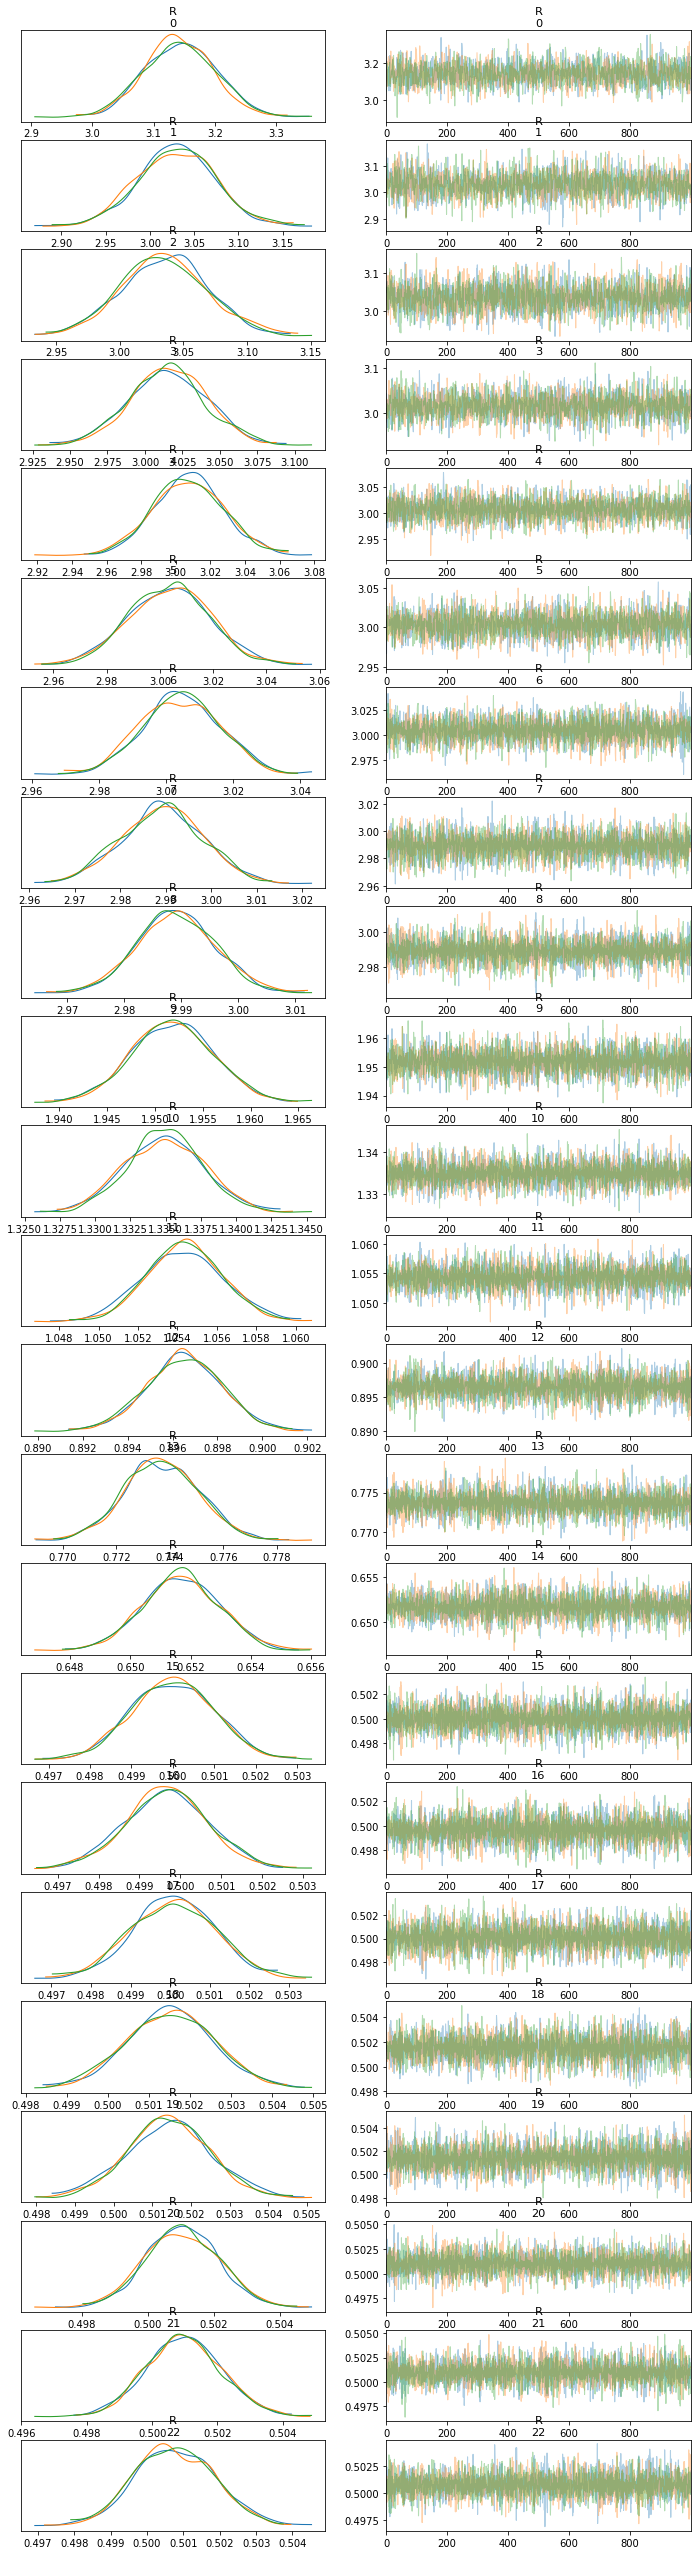

In [11]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

In [12]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit._draws[7:, 500:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, :, 0],
    chain_samples[:, :, 1],
    chain_samples[:, :, 2]), axis=1)

thinning = max(1, int(n_sample * n_chains / 500))

multicat_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[:, ::thinning], axis=1),
    'Lower bound CI': np.quantile(extended_samples[:, ::thinning], 0.025, axis=1),
    'Upper bound CI': np.quantile(extended_samples[:, ::thinning], 0.975, axis=1),
    'Central Probability': (L1+L2) * [0.95]
})

### Aggregated data + Poisson Branching process with multiple categories

In [13]:
agg_multicat_model = """
functions {
    real normalizing_const (array [] real aSI) {
        return sum(aSI);
    }
    real effective_no_infectives (
        int N, int S, int n, int t, array [] real aI, array [] real aSI,
        array [,] real C, array [] real transm, array [] vector ap) {
            real mean;

            mean = 0;
            for(i in 1:n){
                for(j in 1:n){
                    if(t > S) {
                        for(k in (t-S):(t-1)){
                            mean += C[i,j] * transm[j] * ap[k, j] * aI[k] * aSI[S-t+1+k] /
                                normalizing_const(aSI);
                        }
                    }
                    else {
                        for(k in 1:(t-1)){
                            mean += C[i,j] * transm[j] * ap[k, j] * aI[k] * aSI[S-t+1+k] /
                                normalizing_const(aSI);
                        }
                    }
                }
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length serial interval
    int n; // number of categories
    array [n, n] real C; // contact matrix
    array [n] real transm; // transmissibility vector
    array [N] int I; // local incidences for N days
    int tau; // sliding window
    array [S] real revSI; // reversed serial interval
    real a; // prior shape parameter
    real b; // prior rate parameter
    real<lower=0> sigma; // prior std parameter
}
parameters {
    array [N-tau-1] real<lower=0> R; // vector of R numbers
    simplex [n] p[N]; // vector of proportion
}
model {
    for(t in (tau+1):(N-1)) {
        for(k in (t-tau+1):(t+1)) {
            if (effective_no_infectives(N, S, n, k, I, revSI, C, transm, p) != 0) {
                I[k] ~ poisson (
                    R[t-tau] * effective_no_infectives(
                        N, S, n, k, I, revSI, C, transm, p)); // likelihood
                    }
        }
    }
    for(t in 1:(N-tau-1)) {
        R[t] ~ gamma (a, b); // prior of R
    }
    for(t in 1:N) {
        p[t] ~ dirichlet (rep_vector(1, n)); // prior for p
    }
}
"""

agg_multicat_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'n': num_categories,
    'C': contact_matrix,
    'transm': transmissibility,
    'I': agg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b,
    'sigma': sigma}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_11168/1251656915.py:73: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [14]:
posterior = stan.build(
    agg_multicat_model, data=agg_multicat_data, random_seed=10)

fit = posterior.sample(
    num_chains=3, num_samples=1000)

samples = az.from_cmdstanpy(
    fit,
    observed_data='I',
    coords={'observation': list(range(num_timepoints)),
            'covariate': [
                '{}'.format(_)
                for _ in range(num_timepoints - R_t_start)]
            },
    dims={
        'I': ['observation'],
        'R': ['covariate'],
        })

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/httpstan_1wcrya5i/model_pe5ykqxp.stan', line 46, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/httpstan_1wcrya5i/model_pe5ykqxp.stan', line 51, column 12: A
    control flow statement depends on parameter(s): p.
Warning in '/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/httpstan_1wcrya5i/model_pe5ykqxp.stan', line 21, column 24: A
    control flow statement inside function effective_no_infectives depends on
    argument t. At
    '/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/httpstan_1wcrya5i/model_pe5ykqxp.stan',
    line 54, column 33 to column 34, the value of t depends on parameter(s):
    p.
Warn

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
R[0]      2.321  0.049   2.232    2.414      0.001    0.000    5045.0   
R[1]      2.268  0.037   2.199    2.338      0.000    0.000    5894.0   
R[2]      2.281  0.028   2.228    2.334      0.000    0.000    5596.0   
R[3]      2.258  0.021   2.217    2.297      0.000    0.000    4417.0   
R[4]      2.237  0.016   2.209    2.268      0.000    0.000    5695.0   
...         ...    ...     ...      ...        ...      ...       ...   
p[28, 1]  0.330  0.240   0.000    0.769      0.004    0.003    4023.0   
p[28, 2]  0.336  0.243   0.000    0.776      0.004    0.003    3796.0   
p[29, 0]  0.331  0.236   0.001    0.770      0.003    0.003    6141.0   
p[29, 1]  0.335  0.237   0.000    0.752      0.004    0.003    4761.0   
p[29, 2]  0.335  0.232   0.000    0.753      0.003    0.003    4417.0   

          ess_tail  r_hat  
R[0]        1522.0    1.0  
R[1]        2340.0    1.0  
R[2]        2199.0    1.0  
R[3]        2244.0    1.0  
R[4]        2497.0    1.0  
...            ...    ...  
p[28, 1]    2096.0    1.0  
p[28, 2]    1728.0    1.0  
p[29, 0]    1776.0    1.0  
p[29, 1]    1798.0    1.0  
p[29, 2]    2036.0    1.0  

[113 rows x 9 columns]

array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

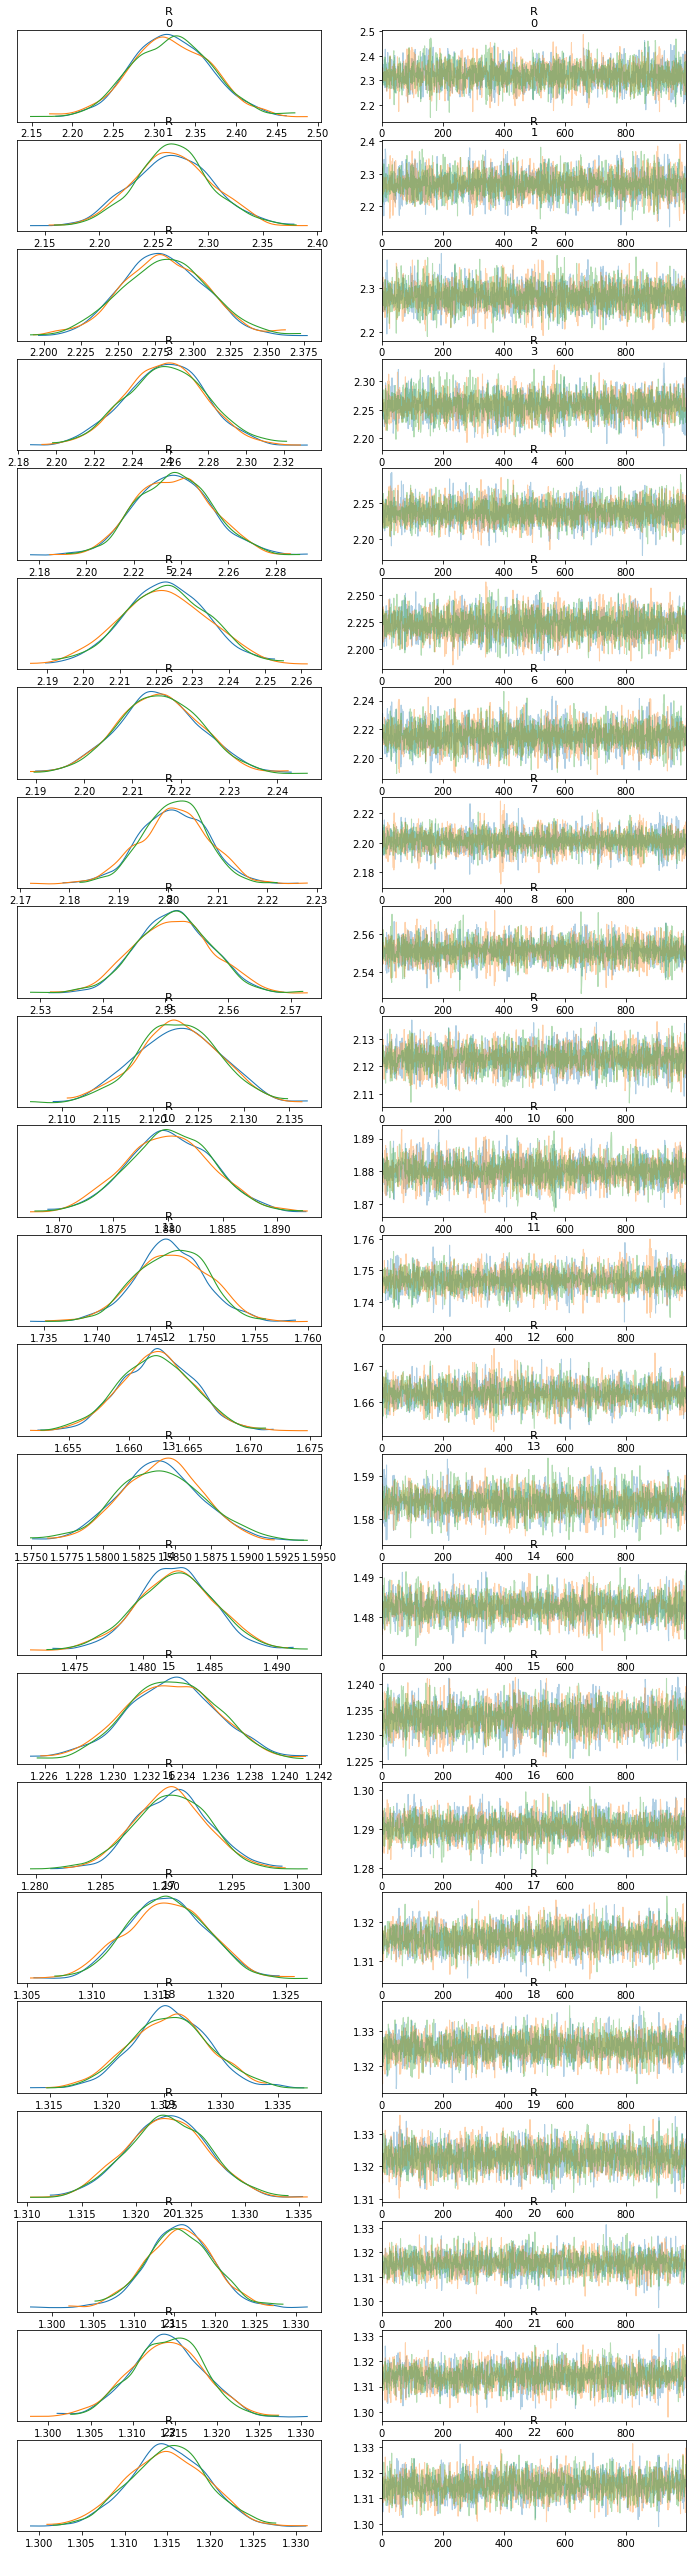

In [15]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

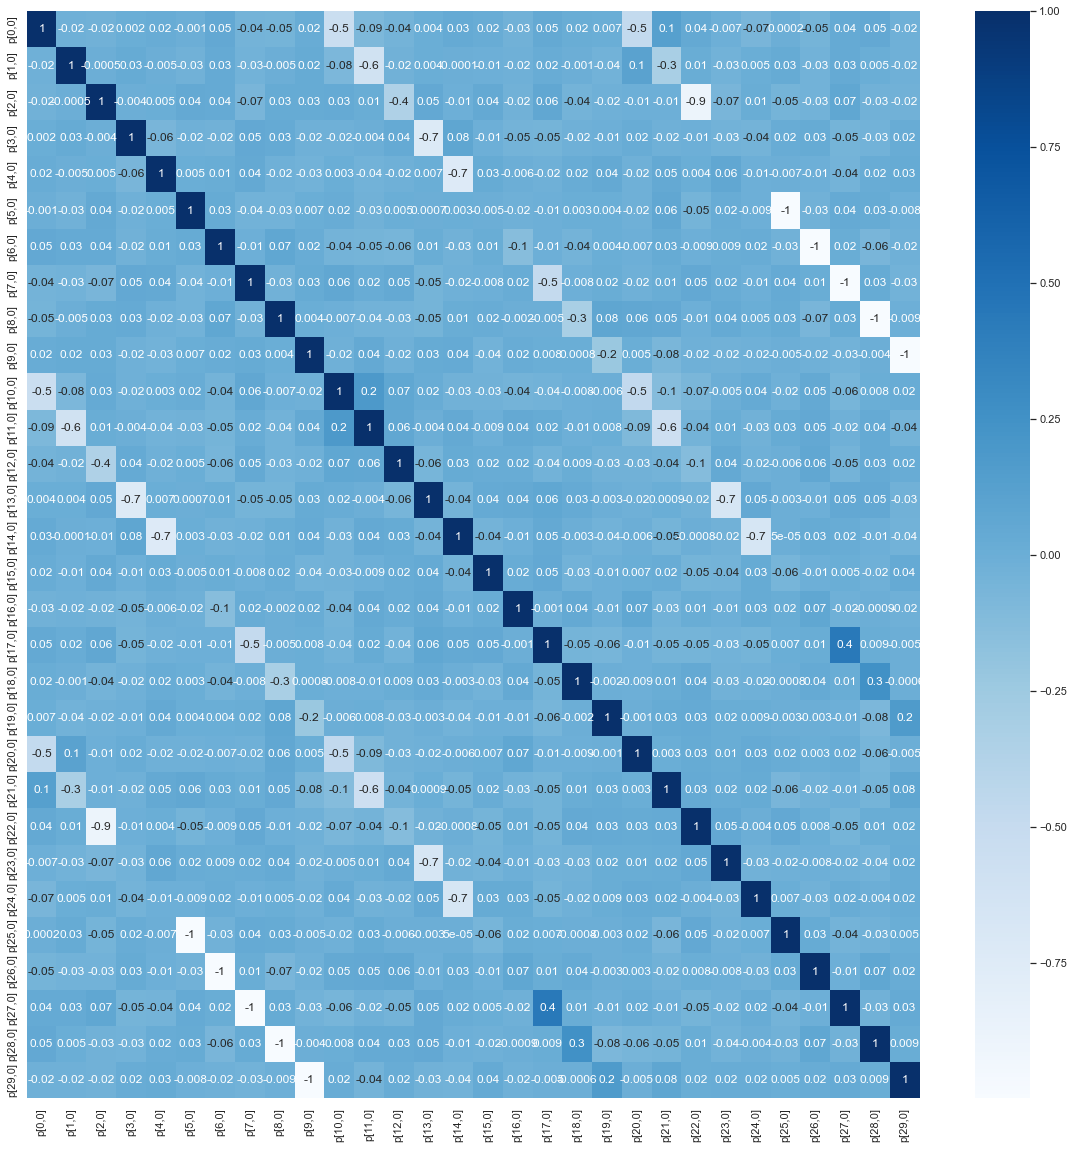

In [16]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
p_chain_samples = fit._draws[(num_timepoints - R_t_start +7)::num_categories, 500:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = p_chain_samples.shape

extended_p_samples = np.concatenate((
    p_chain_samples[:, :, 0],
    p_chain_samples[:, :, 1],
    p_chain_samples[:, :, 2]), axis=1)

df = pd.DataFrame(
    np.transpose(extended_p_samples),
    columns=[
        'p[{},0]'.format(_)
        for _ in range(num_timepoints)])

plt.figure(figsize=(20,20))
sns.set_theme(style="white")
corr = df.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

In [17]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit._draws[7:(num_timepoints - R_t_start +7), 500:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, :, 0],
    chain_samples[:, :, 1],
    chain_samples[:, :, 2]), axis=1)

thinning = max(1, int(n_sample * n_chains / 500))

agg_multicat_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[:, ::thinning], axis=1),
    'Lower bound CI': np.quantile(extended_samples[:, ::thinning], 0.025, axis=1),
    'Upper bound CI': np.quantile(extended_samples[:, ::thinning], 0.975, axis=1),
    'Central Probability': (L1+L2) * [0.95]
})

### Aggregated data + Poisson Branching process

In [18]:
poisson_model = """
functions {
    real normalizing_const (array [] real aSI) {
        return sum(aSI);
    }
    real effective_no_infectives (
        int N, int S, int t, array [] real aI, array [] real aSI) {
            real mean;
            if(t > S) {
                mean = (
                    dot_product(aI[(t-S):(t-1)], aSI) /
                    normalizing_const(aSI));
            }
            else {
                mean = (
                    dot_product(aI[:(t-1)], aSI[(S-t+2):]) /
                    normalizing_const(aSI));
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length serial interval
    array [N] int I; // local incidences for N days
    int tau; // sliding window
    array [S] real revSI; // reversed serial interval
    real a; // prior shape parameter
    real b; // prior rate parameter
    real<lower=0> sigma; // prior std parameter
}
parameters {
    array [N-tau-1] real<lower=0> R; // vector of R numbers
}
model {
    for(t in (tau+1):(N-1)) {
        for(k in (t-tau+1):(t+1)) {
            if (effective_no_infectives(N, S, k, I, revSI) != 0) {
                I[k] ~ poisson (
                    R[t-tau] * effective_no_infectives(
                        N, S, k, I, revSI)); // likelihood
                    }
        }
    }
    for(t in 1:(N-tau-1)) {
        R[t] ~ gamma (a, b); // prior of R
    }
}
"""

poisson_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'I': agg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b,
    'sigma': sigma}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_11168/1887272557.py:54: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [19]:
posterior = stan.build(
    poisson_model, data=poisson_data, random_seed=10)

fit = posterior.sample(
    num_chains=3, num_samples=1000)

samples = az.from_cmdstanpy(
    fit,
    observed_data='I',
    coords={'observation': list(range(num_timepoints)),
            'covariate': [
                '{}'.format(_)
                for _ in range(num_timepoints - R_t_start)]
            },
    dims={
        'I': ['observation'],
        'R': ['covariate']
        })

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   2% (102/6000)
Sampling:   3% (201/6000)
Sampling:   5% (300/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  28% (1700/6000)
Sampling:  32% (1900/6000)
Sampling:  35% (2100/6000)
Sampling:  37% (2200/6000)
Sampling:  40% (2400/6000)
Sampling:  42% (2500/6000)
Sampling:  62% (3700/6000)
Sampling:  80% (4800/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.001148 seconds
  1000 transitions using 1

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
R[0]   5.251  0.098   5.066    5.429      0.002    0.001    2231.0    2252.0   
R[1]   5.127  0.074   4.991    5.263      0.001    0.001    2864.0    2385.0   
R[2]   5.201  0.056   5.102    5.312      0.001    0.001    2027.0    2295.0   
R[3]   5.223  0.047   5.138    5.311      0.001    0.001    2738.0    2082.0   
R[4]   5.246  0.034   5.183    5.313      0.001    0.000    2964.0    2476.0   
R[5]   5.263  0.027   5.210    5.312      0.000    0.000    3160.0    2022.0   
R[6]   5.277  0.021   5.238    5.318      0.000    0.000    4335.0    1774.0   
R[7]   5.260  0.016   5.231    5.289      0.000    0.000    6423.0    2193.0   
R[8]   5.260  0.012   5.238    5.284      0.000    0.000    8765.0    2463.0   
R[9]   3.436  0.008   3.422    3.450      0.000    0.000    7503.0    1654.0   
R[10]  2.350  0.005   2.342    2.360      0.000    0.000    7401.0    2255.0   
R[11]  1.857  0.004   1.850    1.864      0.000    0.000    8340.0    1857.0   
R[12]  1.579  0.003   1.573    1.584      0.000    0.000    7196.0    2241.0   
R[13]  1.362  0.003   1.358    1.367      0.000    0.000    8713.0    2426.0   
R[14]  1.148  0.002   1.144    1.152      0.000    0.000    8524.0    2148.0   
R[15]  0.881  0.002   0.877    0.884      0.000    0.000    6254.0    1808.0   
R[16]  0.880  0.002   0.877    0.883      0.000    0.000    8554.0    2244.0   
R[17]  0.881  0.002   0.878    0.884      0.000    0.000    8153.0    2364.0   
R[18]  0.884  0.002   0.880    0.887      0.000    0.000    8233.0    2359.0   
R[19]  0.884  0.002   0.880    0.887      0.000    0.000    8997.0    2180.0   
R[20]  0.883  0.002   0.880    0.887      0.000    0.000    8755.0    2421.0   
R[21]  0.884  0.002   0.880    0.887      0.000    0.000    8884.0    2305.0   
R[22]  0.884  0.002   0.880    0.887      0.000    0.000    7335.0    2217.0   

       r_hat  
R[0]     1.0  
R[1]     1.0  
R[2]     1.0  
R[3]     1.0  
R[4]     1.0  
R[5]     1.0  
R[6]     1.0  
R[7]     1.0  
R[8]     1.0  
R[9]     1.0  
R[10]    1.0  
R[11]    1.0  
R[12]    1.0  
R[13]    1.0  
R[14]    1.0  
R[15]    1.0  
R[16]    1.0  
R[17]    1.0  
R[18]    1.0  
R[19]    1.0  
R[20]    1.0  
R[21]    1.0  
R[22]    1.0

array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

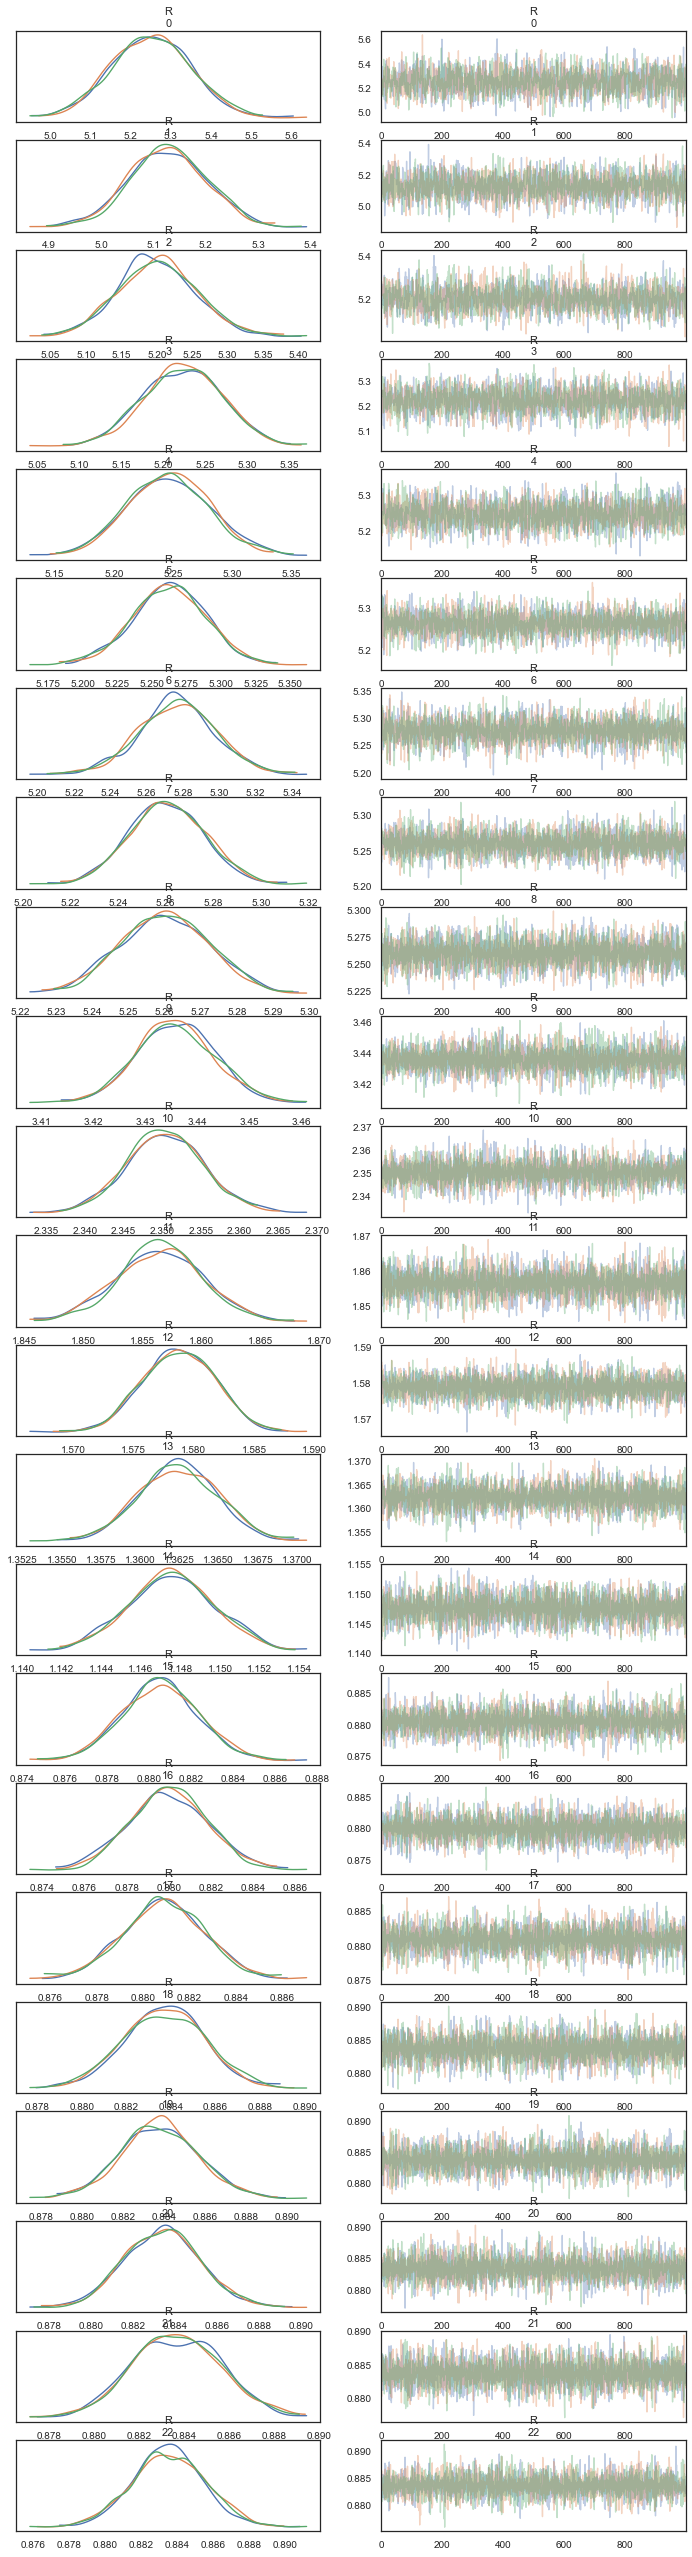

In [20]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

In [21]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit._draws[7:, 500:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, :, 0],
    chain_samples[:, :, 1],
    chain_samples[:, :, 2]), axis=1)

thinning = max(1, int(n_sample * n_chains / 500))

N_pois_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[:, ::thinning], axis=1)/N_corr,
    'Lower bound CI': np.quantile(extended_samples[:, ::thinning], 0.025, axis=1)/N_corr,
    'Upper bound CI': np.quantile(extended_samples[:, ::thinning], 0.975, axis=1)/N_corr,
    'Central Probability': (L1+L2) * [0.95]
})

T_pois_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.divide(np.mean(extended_samples[:, ::thinning], axis=1), T_corr),
    'Lower bound CI': np.divide(np.quantile(extended_samples[:, ::thinning], 0.025, axis=1), T_corr),
    'Upper bound CI': np.divide(np.quantile(extended_samples[:, ::thinning], 0.975, axis=1), T_corr),
    'Central Probability': (L1+L2) * [0.95]
})

### Aggregated data + Negative Binomial Branching process

In [22]:
negbin_model = """
functions {
    real normalizing_const (array [] real aSI) {
        return sum(aSI);
    }
    real effective_no_infectives (
        int N, int S, int t, array [] real aI, array [] real aSI) {
            real mean;
            if(t > S) {
                mean = (
                    dot_product(aI[(t-S):(t-1)], aSI) /
                    normalizing_const(aSI));
            }
            else {
                mean = (
                    dot_product(aI[:(t-1)], aSI[(S-t+2):]) /
                    normalizing_const(aSI));
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length serial interval
    array [N] int I; // local incidences for N days
    int tau; // sliding window
    array [S] real revSI; // reversed serial interval
    real a; // prior shape parameter
    real b; // prior rate parameter
    real<lower=0> sigma; // prior std parameter
    real phiShape; // prior shape parameter for phi
    real phiRate; // prior rate parameter for phi
}
parameters {
    array [N-tau-1] real<lower=0> R; // vector of R numbers
    real<lower=0> Phi; // overdispersion
}
model {
    for(t in (tau+1):(N-1)) {
        for(k in (t-tau+1):(t+1)) {
            if (effective_no_infectives(N, S, k, I, revSI) != 0) {
                I[k] ~ neg_binomial (1/Phi, 1/(Phi *
                    (R[t-tau] * effective_no_infectives(
                        N, S, k, I, revSI)))); // likelihood
            }
        }
    }
    for(t in 1:(N-tau-1)) {
        R[t] ~ gamma (a, b); // prior of R
    }
    Phi ~ gamma (phiShape, phiRate); // prior of Phi
}
"""

negbin_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'I': agg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b,
    'sigma': sigma,
    'phiShape': phi_shape,
    'phiRate': phi_rate}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_11168/3120966940.py:58: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [23]:
posterior = stan.build(
    negbin_model, data=negbin_data, random_seed=10)

fit = posterior.sample(
    num_chains=3, num_samples=1000)

samples = az.from_cmdstanpy(
    fit,
    observed_data='I',
    coords={'observation': list(range(num_timepoints)),
            'covariate': [
                '{}'.format(_)
                for _ in range(num_timepoints - R_t_start)]
            },
    dims={
        'I': ['observation'],
        'R': ['covariate']
        })

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   2% (101/6000)
Sampling:   2% (102/6000)
Sampling:   3% (201/6000)
Sampling:   5% (301/6000)
Sampling:   8% (500/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  18% (1100/6000)
Sampling:  22% (1300/6000)
Sampling:  25% (1500/6000)
Sampling:  28% (1700/6000)
Sampling:  32% (1900/6000)
Sampling:  35% (2100/6000)
Sampling:  38% (2300/6000)
Sampling:  42% (2500/6000)
Sampling:  45% (2700/6000)
Sampling:  63% (3800/6000)
Sampling:  82% (4900/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.00197 seconds
  1000 transitions using 10 leapfrog steps per

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
R[0]   5.188  0.892   3.617    6.880      0.012    0.009    6091.0    2486.0   
R[1]   5.174  0.852   3.712    6.815      0.012    0.009    5332.0    2449.0   
R[2]   5.307  0.868   3.742    6.889      0.013    0.010    5054.0    2611.0   
R[3]   5.252  0.788   3.921    6.808      0.011    0.008    6069.0    2372.0   
R[4]   5.293  0.831   3.874    6.870      0.012    0.009    5317.0    2100.0   
R[5]   5.373  0.855   3.836    6.986      0.012    0.009    6081.0    2277.0   
R[6]   5.409  0.878   3.814    7.005      0.013    0.010    5432.0    2200.0   
R[7]   5.365  0.892   3.782    7.013      0.013    0.010    5052.0    1947.0   
R[8]   5.378  0.845   3.971    7.061      0.011    0.009    6658.0    2308.0   
R[9]   4.771  0.765   3.458    6.241      0.011    0.008    5620.0    2547.0   
R[10]  4.123  0.650   3.052    5.418      0.009    0.007    5294.0    2300.0   
R[11]  3.484  0.560   2.456    4.533      0.008    0.006    5225.0    2292.0   
R[12]  2.851  0.467   1.995    3.715      0.007    0.005    5359.0    2173.0   
R[13]  2.215  0.357   1.570    2.859      0.005    0.004    5773.0    2167.0   
R[14]  1.572  0.257   1.115    2.019      0.004    0.003    5216.0    2005.0   
R[15]  0.923  0.155   0.659    1.225      0.002    0.002    6522.0    2164.0   
R[16]  0.921  0.151   0.656    1.199      0.002    0.002    5446.0    2161.0   
R[17]  0.924  0.150   0.648    1.198      0.002    0.002    5226.0    2247.0   
R[18]  0.930  0.157   0.646    1.208      0.002    0.002    6330.0    2394.0   
R[19]  0.926  0.152   0.678    1.225      0.002    0.002    5346.0    2515.0   
R[20]  0.921  0.144   0.666    1.186      0.002    0.002    5288.0    2388.0   
R[21]  0.922  0.146   0.661    1.196      0.002    0.002    5537.0    2321.0   
R[22]  0.923  0.146   0.665    1.201      0.002    0.002    5396.0    2019.0   
Phi    0.174  0.020   0.137    0.211      0.000    0.000    4062.0    2128.0   

       r_hat  
R[0]     1.0  
R[1]     1.0  
R[2]     1.0  
R[3]     1.0  
R[4]     1.0  
R[5]     1.0  
R[6]     1.0  
R[7]     1.0  
R[8]     1.0  
R[9]     1.0  
R[10]    1.0  
R[11]    1.0  
R[12]    1.0  
R[13]    1.0  
R[14]    1.0  
R[15]    1.0  
R[16]    1.0  
R[17]    1.0  
R[18]    1.0  
R[19]    1.0  
R[20]    1.0  
R[21]    1.0  
R[22]    1.0  
Phi      1.0

array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

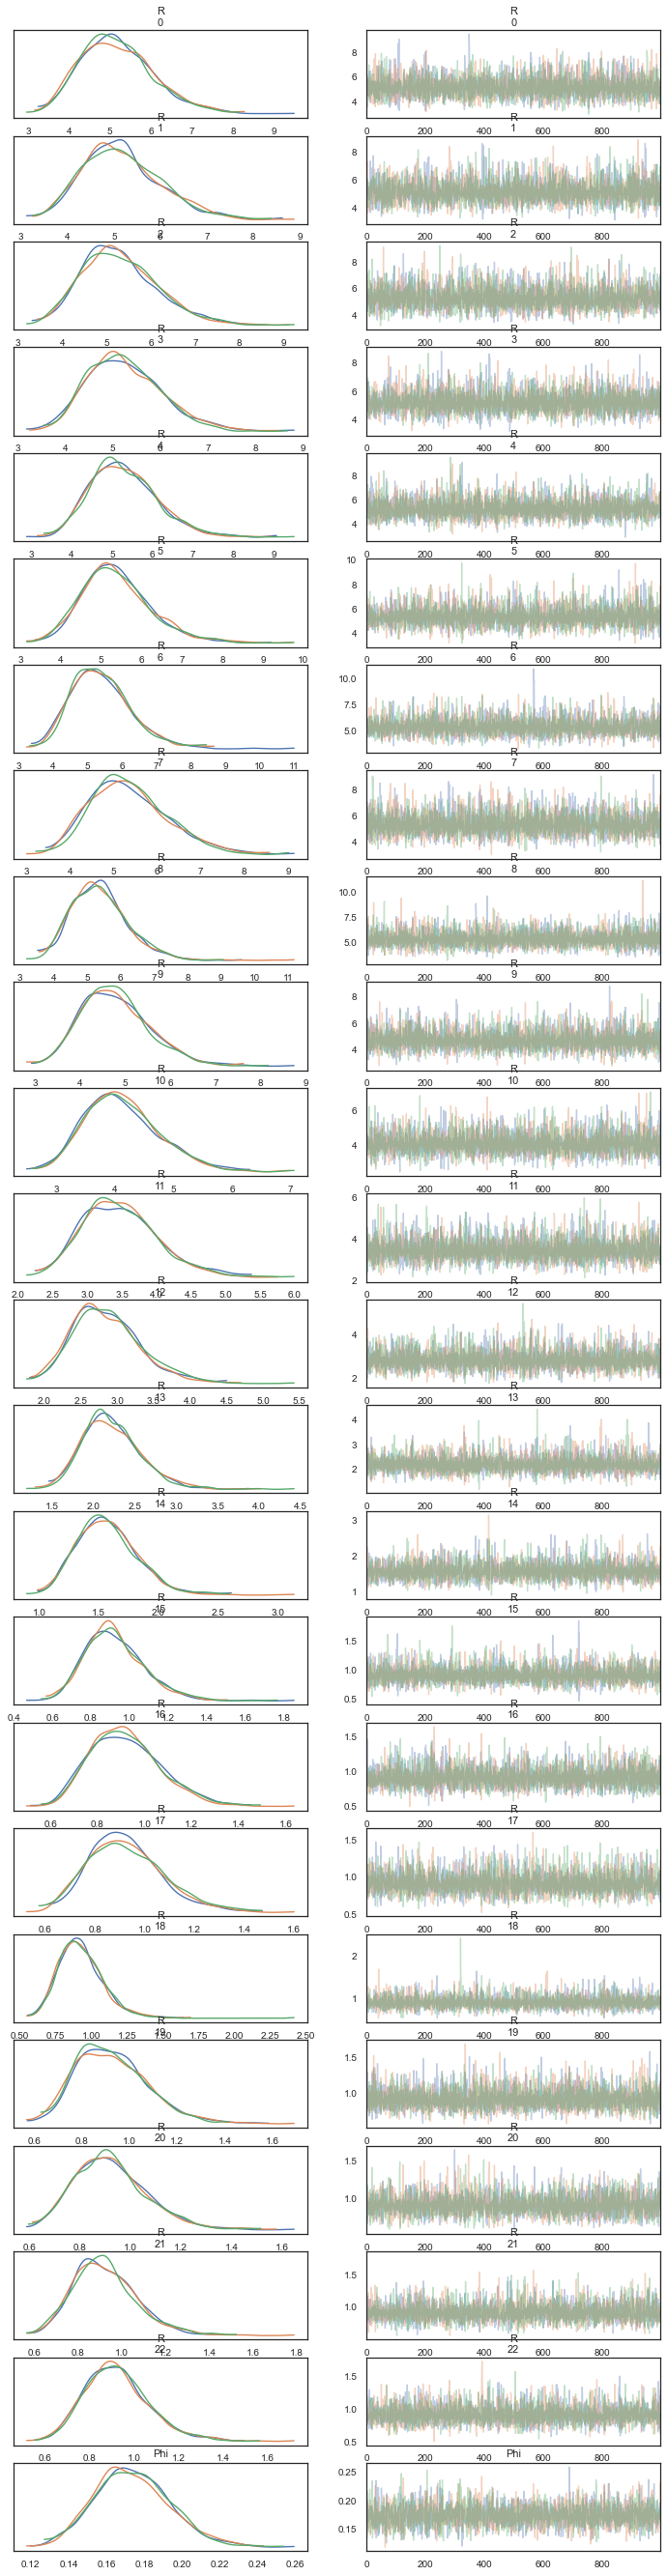

In [24]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start+1)

az.plot_trace(
    samples,
    var_names=('R', 'Phi'),
    filter_vars='like',
    compact=False)

In [25]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit._draws[7:-1, 500:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, :, 0],
    chain_samples[:, :, 1],
    chain_samples[:, :, 2]), axis=1)

thinning = max(1, int(n_sample * n_chains / 500))

N_negbin_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[:, ::thinning]/N_corr, axis=1),
    'Lower bound CI': np.quantile(extended_samples[:, ::thinning]/N_corr, 0.025, axis=1),
    'Upper bound CI': np.quantile(extended_samples[:, ::thinning]/N_corr, 0.975, axis=1),
    'Central Probability': (L1+L2) * [0.95]
})

T_negbin_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(np.divide(extended_samples[:, ::thinning], T_corr), axis=1),
    'Lower bound CI': np.quantile(np.divide(extended_samples[:, ::thinning], T_corr), 0.025, axis=1),
    'Upper bound CI': np.quantile(np.divide(extended_samples[:, ::thinning], T_corr), 0.975, axis=1),
    'Central Probability': (L1+L2) * [0.95]
})

## Inference plot using class method results

In [26]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(multicat_intervals, model_type='multi_categorical')
fig.add_interval_rt(agg_multicat_intervals, colour='orange', model_type='agg_multi_categorical')
fig.add_interval_rt(N_pois_intervals, colour='pink', shape='dash', model_type='poisson Naive correction term')
fig.add_interval_rt(T_pois_intervals, colour='red', model_type='poisson True correction term')
fig.add_interval_rt(N_negbin_intervals, colour='deepskyblue', shape='dash', model_type='negative_binomial Naive correction term')
fig.add_interval_rt(T_negbin_intervals, colour='blue', model_type='negative_binomial True correction term')

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.

